#### Gradient inference with functional observations in gpytorch (dynamic effect example)

In this notebook, we demonstrate the inference of gradient (marginal effect) from functional observations with dynamic time effects, training an RBF kernel Gaussian process. We focus 2-dimensional covariates.

In [27]:
# LOAD PACKAGES
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.models.exact_prediction_strategies import prediction_strategy
from gpytorch.means.mean import Mean
from gpytorch.kernels.kernel import Kernel
from gpytorch.lazy import InterpolatedLazyTensor
from gpytorch.utils.broadcasting import _mul_broadcast_shape
from sklearn.gaussian_process.kernels import RBF
from numpy.random import multivariate_normal

Set up data n = 50, D = 2, T = 20 with dynamic unit effects

$x_{it}\in \mathbb{R}^D$ 

$y_{it} = \sum\limits_{d=1}^D \sin(x_{it}*d)/d + b_{it} + \varepsilon$

$[b_{i1},\dots,b_{iT}]\sim\mathbb{GP}(0,K_t)$

$K_t(t,t')=\exp(-\frac{(t-t')^2}{2\ell^2}), \quad \ell=T/4=5$

$\varepsilon\sim\mathbb{N}(0,0.1^2)$

In [59]:
# define data
D = 2
n = 50
T = 20
torch.random.manual_seed(12345)
noise_sd = 0.1
soboleng = torch.quasirandom.SobolEngine(dimension=D)
train_x = 4*soboleng.draw(n*T)-2
train_i = torch.zeros((n*T,1))
train_t = torch.zeros((n*T,1))
train_y = torch.randn(n*T) * noise_sd

unit_effects = torch.zeros((n,T))
unit_kernel = RBF(length_scale=T/4)
unit_cov = unit_kernel(X=np.arange(T).reshape((-1,1))) + 1e-6*np.eye(T)

ARD_lss = 1 + torch.arange(D)

for i in range(n):
    # generate time effect as unit deviation
    unit_effects[i,] = torch.tensor(multivariate_normal(np.zeros((T,)),unit_cov))
    # add covariate effect
    for t in range(T):
        # add dynamic time effect as unit deviation
        train_y[t+i*T,] += unit_effects[i, t]
        train_i[t+i*T,] = i
        train_t[t+i*T,] = t
        for k in range(D):
            train_y[t+i*T,] += torch.sin(train_x[t+i*T,k]*ARD_lss[k])/ARD_lss[k]

define indicator kernel for dynamic time effect

In [39]:
class myIndicatorKernel(Kernel):
    r"""
    A kernel for discrete indices. Kernel is defined by a lookup table.

    """

    def __init__(self, num_tasks, **kwargs):
        super().__init__(**kwargs)

        self.num_tasks = num_tasks

    def covar_matrix(self):
        res = torch.eye(self.num_tasks)
        return res

    def forward(self, i1, i2, **params):
        covar_matrix = self.covar_matrix()
        batch_shape = _mul_broadcast_shape(i1.shape[:-2], self.batch_shape)
        index1_shape = batch_shape + i1.shape[-2:]
        index2_shape = batch_shape + i2.shape[-2:]

        res = InterpolatedLazyTensor(
            base_lazy_tensor=covar_matrix,
            left_interp_indices=i1.long().expand(index1_shape),
            right_interp_indices=i2.long().expand(index2_shape),
        )
        return res

define a GP model with linear mean and sqrexp ARD kernel with gradient; add a zero-meaned GP model for dynamic time effect

In [65]:
class DerivativeExactGP(gpytorch.models.ExactGP):
    """Derivative of the ExactGPModel w.r.t. the test points x.
    Since differentiation is a linear operator this is again a Gaussian process.
    Attributes:
        train_x: (N x D) The training features X.
        train_i: (N x 1) The training unit index i.
        train_t: (N x 1) The training time index t.
        train_y: (N x 1) The training targets y.
        likelihood: gpytorch likelihood.
    """

    def __init__(
        self,
        train_x=None,
        train_i=None,
        train_t=None,
        train_y=None,
        likelihood=None
    ):
        """Inits GP model with data and a Gaussian likelihood."""
        if likelihood is None:
            likelihood = GaussianLikelihood()
        if train_y is not None:
            train_y = train_y.squeeze(-1)
        super(DerivativeExactGP, self).__init__((train_x,train_i,train_t), train_y, likelihood)

        self.D = train_x.shape[1]
        self.n = train_i.max().long().item()+1
        self.T = train_t.max().long().item()+1
        self.N = train_x.shape[0]
        # self.train_inputs = (train_x, train_i, train_t)
        # self.train_targets = train_y

        # dynamic time effects
        self.t_covar_module = ScaleKernel(RBFKernel())
        self.i_covar_module = myIndicatorKernel(self.n)

        # covariate effect with linear mean and sqrexp ARD kernel
        self.mean_module = LinearMean(input_size=self.D)
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=self.D))

    def forward(self, x, i , t):
        """Compute the prior latent distribution on a given input.
        Typically, this will involve a mean and kernel function. The result must be a
        MultivariateNormal. Calling this model will return the posterior of the latent
        Gaussian process when conditioned on the training data. The output will be a
        MultivariateNormal.
        Args:
            x: (n x D) The test points.
            i: (n x 1) The test unit index.
            t: (n x 1) The test time index.
        Returns:
            A MultivariateNormal.
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x) + self.t_covar_module(t).mul(self.i_covar_module(i))
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def get_L_lower(self):
        """Get Cholesky decomposition L, where L is a lower triangular matrix.
        Returns:
            Cholesky decomposition L.
        """
        return (
            self.prediction_strategy.lik_train_train_covar.root_decomposition()
            .root.evaluate()
            .detach()
        )

    def get_KXX_inv(self):
        """Get the inverse matrix of K(X,X).
        Returns:
            The inverse of K(X,X).
        """
        L_inv_upper = self.prediction_strategy.covar_cache.detach()
        return L_inv_upper @ L_inv_upper.transpose(0, 1)

    def get_KXX_inv_old(self):
        """Get the inverse matrix of K(X,X).
        Not as efficient as get_KXX_inv.
        Returns:
            The inverse of K(X,X).
        """
        X = self.train_inputs[0]
        sigma_n = self.likelihood.noise_covar.noise.detach()
        KXX = torch.eye(X.shape[0]) * sigma_n + self.covar_module(X).evaluate()
        return torch.inverse(KXX)

    def _get_KxX_dx(self, x):
        """Computes the analytic derivative of the kernel K(x,X) w.r.t. x.
        Args:
            x: (n x D) Test points.
        Returns:
            (n x D) The derivative of K(x,X) w.r.t. x.
        """
        X = self.train_inputs[0]
        n = x.shape[0]
        K_xX = self.covar_module(x, X).evaluate()
        lengthscale = self.covar_module.base_kernel.lengthscale.detach()
        return (
            -torch.eye(self.D, device=x.device)
            / lengthscale ** 2
            @ (
                (x.view(n, 1, self.D) - X.view(1, self.N, self.D))
                * K_xX.view(n, self.N, 1)
            ).transpose(1, 2)
        )

    def _get_Kxx_dx2(self):
        """Computes the analytic second derivative of the kernel K(x,x) w.r.t. x.
        Args:
            x: (n x D) Test points.
        Returns:
            (n x D x D) The second derivative of K(x,x) w.r.t. x.
        """
        lengthscale = self.covar_module.base_kernel.lengthscale.detach()
        sigma_f = self.covar_module.outputscale.detach()
        return (
            torch.eye(self.D, device=lengthscale.device) / lengthscale ** 2
        ) * sigma_f

    def _get_mu_dx(self, x):
        """Get the derivative of mu(x).
        Returns:
            The gradient of linear mu(x) wrt x.
        """
        return self.mean_module.weights.expand(x.t().shape).t() # x.grad.data.reshape((-1,self.D))

    def posterior_derivative(self, x):
        """Computes the posterior of the derivative of the GP w.r.t. the given test
        points x.
        Args:
            x: (n x D) Test points.
        Returns:
            A GPyTorchPosterior.
        """
        mu_x_dx = self._get_mu_dx(x)

        with torch.no_grad():
            if self.prediction_strategy is None:
                train_output = super().__call__(self.train_inputs)
                # Create the prediction strategy for
                self.prediction_strategy = prediction_strategy(
                    train_inputs=self.train_inputs,
                    train_prior_dist=train_output,
                    train_labels=self.train_targets,
                    likelihood=self.likelihood,
                )

            K_xX_dx = self._get_KxX_dx(x)
            mu_prior = self.mean_module(self.train_inputs[0])
            mean_d = mu_x_dx + K_xX_dx @ self.get_KXX_inv() @ (self.train_targets - mu_prior)
            variance_d = (
                self._get_Kxx_dx2() - K_xX_dx @ self.get_KXX_inv() @ K_xX_dx.transpose(1, 2)
            )
            variance_d = variance_d.clamp_min(1e-8)

        return mean_d, variance_d

define likelihood and derivativeExactGP model

In [70]:
likelihood = GaussianLikelihood()
model = DerivativeExactGP(train_x,train_i,train_t, train_y, likelihood)

learn hyperparameter by minimizing the negative log likelihood using ADAM optimizer

In [71]:
# train
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x,train_i,train_t)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f  slope: %.3f   lengthscale: %.3f  outputscale: %.3f  noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.mean_module.weights[0].item(),
        model.covar_module.base_kernel.lengthscale[0,0].item(),
        model.covar_module.outputscale.item(),
        likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.384  slope: 1.724   lengthscale: 0.693  outputscale: 0.693  noise: 0.693
Iter 2/50 - Loss: 1.342  slope: 1.624   lengthscale: 0.744  outputscale: 0.744  noise: 0.644
Iter 3/50 - Loss: 1.291  slope: 1.525   lengthscale: 0.797  outputscale: 0.796  noise: 0.598
Iter 4/50 - Loss: 1.260  slope: 1.427   lengthscale: 0.851  outputscale: 0.848  noise: 0.554
Iter 5/50 - Loss: 1.212  slope: 1.331   lengthscale: 0.907  outputscale: 0.898  noise: 0.513
Iter 6/50 - Loss: 1.183  slope: 1.238   lengthscale: 0.965  outputscale: 0.945  noise: 0.474
Iter 7/50 - Loss: 1.143  slope: 1.146   lengthscale: 1.023  outputscale: 0.990  noise: 0.437
Iter 8/50 - Loss: 1.103  slope: 1.058   lengthscale: 1.081  outputscale: 1.030  noise: 0.402
Iter 9/50 - Loss: 1.067  slope: 0.973   lengthscale: 1.141  outputscale: 1.065  noise: 0.369
Iter 10/50 - Loss: 1.025  slope: 0.890   lengthscale: 1.202  outputscale: 1.095  noise: 0.339
Iter 11/50 - Loss: 0.975  slope: 0.811   lengthscale: 1.262  outputsc

plot partial gradients

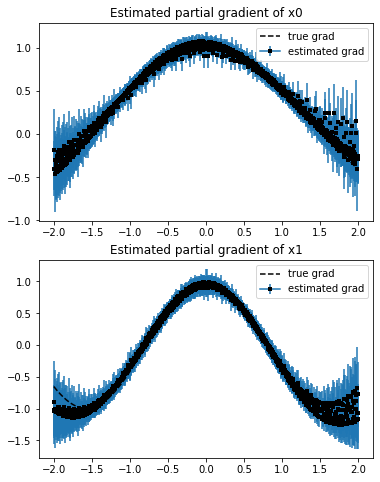

In [72]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x, train_i, train_t))

with torch.no_grad():
    mean_d, variance_d = model.posterior_derivative(train_x)
    variance_d = torch.diagonal(variance_d, dim1=1,dim2=2)
    
_, ax = plt.subplots(nrows=2,ncols=1,figsize=(6, 8))

for k in range(D):
    sorted, idx = torch.sort(train_x[:,k])
    ax[k].plot(sorted.numpy(), torch.cos(sorted*ARD_lss[k]).numpy(), '--k',label='true grad')
    ax[k].errorbar(sorted.numpy(), mean_d[idx,k].numpy(), yerr=2*variance_d[idx,k].numpy()**0.5,\
            marker='s', mfc='red', mec='black', ms=2, mew=2,label='estimated grad')

    ax[k].legend()
    ax[k].set_title('Estimated partial gradient of x' + str(k))

plt.show()